In [242]:
import numpy as np
import matplotlib.pyplot as plt

In [243]:
inputs = np.array([
    [0,0,0,0],
    [1,1,1,1],
    [0,1,1,0],
    [1,0,0,1]
]) # Input samples, sample i is inputs[i,:]
targets = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,1,0,0],
    [1,0,0,0]
]) # Corresponding targets, inputs[i,:] has the corresponding target of target[i,:]

In [244]:
# Parameters
N_hidden_layers = 1 # number of hidden layers
N_layers = N_hidden_layers + 2 # i'm adding an extra layer for input and output, hence the +2
N_hidden_neurons = 256 # number of hidden neurons per layer (for simplicity, assume all hidden layers have same # neurons)
N_epochs = 1000 # Train for some number of epochs
learning_rate = 0.1 # A learning rate which seems to work

# An array to store the number of neurons per layer = [input size, N_hidden_neurons, ..., N_hidden_neurons, output size]
input_size = inputs.shape[1]
output_size = targets.shape[1]
N_neurons_perLayer = [input_size] + [N_hidden_neurons for _ in range(N_hidden_layers)] + [output_size]

# For plotting
error_overTime = np.zeros(N_epochs)

In [245]:
# 2D array of neurons representing our network
# Neuron i in layer j is neurons[j][i]
neurons = np.zeros(shape=(N_layers, N_hidden_neurons))
# the input and output layers have less than N_hidden_neurons, but it's easier to keep the matrix square
# so the 2D matrix has more spaces in the first and last rows than it needs, just ignore the left over

# Weights for the network, randomly initialized between -.1 and .1, good to be small and random
weights = np.random.uniform(low=-.1,high=0.1,size=[N_layers-1,N_hidden_neurons,N_hidden_neurons])
# There are weights between each layer of neurons, so a total of N_layers-1
# Assume fully-connected, so there are N_hidden_neurons^2 weights between each layer
# weights[L][i][j] is the weight from neuron i in layer L, to neuron j in layer L+1

# again, the first and last layers don't use all the weights as they have fewer neurons, but 
# keep the matrix rectangular and ignore the left over

In [246]:
# For backpropagation we are going to compute a number of gradients
# taken from video: https://www.youtube.com/watch?v=VCT1N0EsGj0

# dE / dy , the error with respect to the value of a neuron (how the error changes if we change the value of this neuron)
dEdy = np.zeros(shape=(N_layers,N_hidden_neurons))

# dE / dz , the error with respect to the input to a neuron (how the error changes if we change the input to this neuron)
dEdz = np.zeros(shape=(N_layers,N_hidden_neurons))

# dE / dw , the error with respect to a weight (how the error changes if we change the values of this weight)
dEdw = np.zeros(shape=(N_layers,N_hidden_neurons, N_hidden_neurons))

# We first compute dE/dy for neurons in a layer
# Use that to compute dE/dz for their inputs
# Then use that (plus the value of neurons in previous layer) to compute the dE/dw for the weights
# this dE/dw is the called the gradient
# gradient descent is updating our weights in the direction of the gradient to lower the error

In [247]:
# Train
for epoch in range(N_epochs):
    # Take one sample at a time
    for sampleIndex in range(inputs.shape[0]):
        sample = inputs[sampleIndex,:] # Input sample
        target = targets[sampleIndex,:] # What the output should be
        
        # Set the input neurons
        for i in range(inputs.shape[1]):
            neurons[0][i] = sample[i] # Set the neurons to the integers in sample
        
        ########### Forward propagate ######################################################
        for L in range(1, N_layers): # For each layer
            # Computing the value of neurons in layer L
            for i in range(N_neurons_perLayer[L]): # For each neuron in that layer
                z = 0 # Start at 0
                # Compute the weighted sum of neurons in previous layer to this neuron
                for j in range(N_neurons_perLayer[L-1]): # For each neuron in previous layer
                    n = neurons[L-1][j] # Neuron in previous layer
                    w = weights[L-1][j][i] # Weight from previous layer, neuron j, to this neuron i
                    z += n * w
                # After completing weight sum, do non-linear activation
                value = 1 / ( 1 + np.exp(-z)) # take the sigmoid function of the sum
                neurons[L][i] = value # Done computing this neuron, save it
        ########### End Forward propagate ######################################################
        
#         total_error = 0
#         # Report the error so we can see if it's improving
#         for i in range(output_size):
#             total_error += 1/2* (target[i]-neurons[N_layers-1][i])**2
#         print("Total error was",total_Error)
#         print('----')
#         print(target)
#         print(neurons[N_layers-1][:4])
#         print('----')
        
        ########### Back propagate ######################################################
                
        # Now that forward propagation is done, the output neurons are supposed to be close to the target
        # Start by finding the error, the difference between target and the value of the neurons
        # Generally, y is going to correspond to the value of a neuron, t is the target for a single neuron
        # We define the error as the squared error
        # E = 1/2 * (t - y)^2
        # The value of this function is it has a nice derivative
        # dE/dy = -(t - y)
        # And this is where we start getting our gradients that we can use to update the weights
        
        # Compute dE/dy for the output layer
        outputLayer = N_layers-1
        for i in range(output_size): 
            y = neurons[outputLayer][i] # value of this output neuron
            dEdy[outputLayer][i] = -(target[i] - y) 
            
        # Each neuron has a dE/dy, now we can use its own value to compute its dE/dz 
        for i in range(output_size):  
            # since y (the value of a neuron) is computed as a sigmoid
            # it's derivative with respect to its input z (the weighted sum)
            # is y*(1-y) 
            # because if f(x) = sigmoid(x)
            # df(x)/dx = f(x)*(1-f(x)) by definition
            
            # Value of neuron
            y = neurons[outputLayer][i]
            # dy/dz of the neuron
            dydz = y*(1-y)
            # dE/dz = dy/dz*dE/dy
            dEdz[outputLayer][i] = dydz * dEdy[outputLayer][i]
            
        # Now, we have dE/dz for the output layer
        # We can work backwards through the network, computing gradients based on these gradients
        for L in range(N_layers-2,-1,-1): # Start at 2nd last and go back to 0 (the input layer)
            # For each neuron in this layer
            for i in range(N_neurons_perLayer[L]): # neuron i of this layer L
                # We know the dE/dz for the following (next) layer 
                # That is the  gradient of error for the inputs to those neurons
                # We can now compute the dE/dy for THESE neurons, since we know how they impact the next neurons
                # dE/dy =  SUM (w*dE/dz)
                # the dE/dy of neuron in this layer, is the sum of its weights to neurons in the next layer
                # times their dE/dz
                # intuition: How the value of this neuron affects the error
                # is how it impacts the error on the input to the next layer
                s = 0 # The sum
                # For each neuron in NEXT layer
                for j in range(N_neurons_perLayer[L+1]):
                    w = weights[L][i][j] # The weight from this neuron to neuron j in next layer
                    s += w * dEdz[L+1][j] # dE/dz of neuron j in next layer
                dEdy[L][i] = s # The sum of all its weights times dE/dzs of next layer
                # We can also immediately compute its own dE/dz by rule previously mentioned
                y = neurons[L][i]
                dEdz[L][i] = y*(1-y)*dEdy[L][i] # it's based on its own dE/dy
                
                # Where it all comes together, this is where the weight gradients can be computed
                # Now that we have dE/dz for neurons in THIS layer, we can compute the gradients
                # of the weights leaving it
                # For each neuron in NEXT layer
                for j in range(N_neurons_perLayer[L+1]):
                    # neuron i of this layer, neuron j of next layer
                    # We need the gradient for weight (w) from this neuron i to neuron j in next layer
                    # We already know dE/dz of the next layer, because we computed that earlier
                    # We have the formula
                    # dE/w = dz/dw*dE/dz 
                    # The gradient of this weight, is how z (input of next layer) changes with respect to this weight
                    # times dE/dz (the gradient of the input to neuron j in next layer, which is already computed)
                    # so dz/dw is the only unknown, how the input of next layer neuron j changes with this weight
                    # but we DO know
                    # The input to neuron j (z) is a weighted sum of neurons times weights
                    # So how that input changes with respect to this weight, is the value of this neuron i
                    # because neuron i times this weight goes into neuron j's input
                    # so dz/dw = y , simply the value of this neuron
                    y = neurons[L][i] # This neuron i's value
                    dEdw[L][i][j] = y * dEdz[L+1][j]
                    # This weights gradient, layer L neuron i to layer L+1 neuron j
                    # is the value of neuron i, times dE/dz of neuron j
                    
        ########### End Back propagate ######################################################
        
        ########### Update weights ######################################################
        # Now forward and back propagation is done  
        # We have computed the gradients for all the weights
        # Now we can update (doing batch size = 1, update gradients after every input)
        for L in range(N_layers-1):
            for i in range(N_neurons_perLayer[L]):
                for j in range(N_neurons_perLayer[L+1]):
                    weights[L][i][j] -= learning_rate * dEdw[L][i][j]
                    # For all weights, subtract the gradient times a learning rate
                    # Go in the direction (up or down) such that the error is more negative
        ########### End update weights ######################################################
                    
                
    ############## Extra, compute the error after every epoch
    # After each epoch, test the total error
    total_error = 0
    es = [0,0,0,0]
    for sampleIndex in range(inputs.shape[0]):
        sample = inputs[sampleIndex,:] # Input sample
        target = targets[sampleIndex,:] # What the output should be        
        # Set the input neurons
        for i in range(inputs.shape[1]):
            neurons[0][i] = sample[i] # Set the neurons to the integers in sample      
        ########### Forward propagate ######################################################
        for L in range(1, N_layers): # For each layer
            # Computing the value of neurons in layer L
            for i in range(N_neurons_perLayer[L]): # For each neuron in that layer
                z = 0 # Start at 0
                # Compute the weighted sum of neurons in previous layer to this neuron
                for j in range(N_neurons_perLayer[L-1]): # For each neuron in previous layer
                    n = neurons[L-1][j] # Neuron in previous layer
                    w = weights[L-1][j][i] # Weight from previous layer, neuron j, to this neuron i
                    z += n * w
                # After completing weight sum, do non-linear activation
                value = 1 / ( 1 + np.exp(-z)) # take the sigmoid function of the sum
                neurons[L][i] = value # Done computing this neuron, save it
        ########### End Forward propagate ######################################################
        # Report the error so we can see if it's improving
        serror = 0
        for i in range(output_size):
            serror += 1/2* (target[i]-neurons[N_layers-1][i])**2
        total_error += serror
        es[sampleIndex] = serror
        print('Target')
        print(target)
        print('Actual')
        print(neurons[N_layers-1][:4])
        print('----')
        
    print("Epoch", epoch, "Total error was", total_error)       
    error_overTime[epoch] = total_error

Target
[0 0 0 1]
Actual
[0.36595008 0.28164571 0.20684557 0.21762824]
----
Target
[0 0 1 0]
Actual
[0.37313816 0.27067753 0.20662756 0.21526993]
----
Target
[0 1 0 0]
Actual
[0.37414829 0.28022239 0.20735878 0.215736  ]
----
Target
[1 0 0 0]
Actual
[0.36494296 0.27207682 0.20610168 0.21716872]
----
Epoch 0 Total error was 1.5354918199850653
Target
[0 0 0 1]
Actual
[0.29333314 0.2368071  0.1850584  0.17294494]
----
Target
[0 0 1 0]
Actual
[0.29951782 0.22687149 0.1851805  0.1700257 ]
----
Target
[0 1 0 0]
Actual
[0.30012857 0.23575594 0.18563614 0.17080272]
----
Target
[1 0 0 0]
Actual
[0.29272461 0.22789986 0.1845914  0.17216684]
----
Epoch 1 Total error was 1.5240412476128462
Target
[0 0 0 1]
Actual
[0.27093075 0.22298992 0.17732904 0.16071196]
----
Target
[0 0 1 0]
Actual
[0.2767995  0.21346495 0.17780953 0.15737609]
----
Target
[0 1 0 0]
Actual
[0.27708248 0.22228281 0.17804218 0.15837218]
----
Target
[1 0 0 0]
Actual
[0.27064628 0.21415638 0.1770856  0.15970943]
----
Epoch 2 Total 

Target
[0 0 0 1]
Actual
[0.26187385 0.22062269 0.1696919  0.16092106]
----
Target
[0 0 1 0]
Actual
[0.2695245  0.21269683 0.17924849 0.14737935]
----
Target
[0 1 0 0]
Actual
[0.26273706 0.22804003 0.17456789 0.15330659]
----
Target
[1 0 0 0]
Actual
[0.26864816 0.20565032 0.1742711  0.15474561]
----
Epoch 25 Total error was 1.506876094616382
Target
[0 0 0 1]
Actual
[0.26216381 0.22094432 0.16959287 0.16130105]
----
Target
[0 0 1 0]
Actual
[0.26991332 0.21307756 0.17956457 0.14728821]
----
Target
[0 1 0 0]
Actual
[0.26280284 0.2287414  0.17465596 0.15344035]
----
Target
[1 0 0 0]
Actual
[0.26926465 0.20567676 0.17439156 0.15488318]
----
Epoch 26 Total error was 1.5057097012504808
Target
[0 0 0 1]
Actual
[0.26245422 0.22126721 0.16949317 0.16168291]
----
Target
[0 0 1 0]
Actual
[0.27030339 0.21345961 0.179882   0.14719633]
----
Target
[0 1 0 0]
Actual
[0.2628682  0.22944662 0.1747439  0.15357441]
----
Target
[1 0 0 0]
Actual
[0.26988358 0.20570272 0.17451244 0.15502092]
----
Epoch 27 Tota

Target
[0 0 0 1]
Actual
[0.27026162 0.23022933 0.16661802 0.17244289]
----
Target
[0 0 1 0]
Actual
[0.2810354  0.22399535 0.18874941 0.14449786]
----
Target
[0 1 0 0]
Actual
[0.26442152 0.24946981 0.17699828 0.15720586]
----
Target
[1 0 0 0]
Actual
[0.28710794 0.20618544 0.1778498  0.15870727]
----
Epoch 53 Total error was 1.4718118200925168
Target
[0 0 0 1]
Actual
[0.27057592 0.23060081 0.1664943  0.17289609]
----
Target
[0 0 1 0]
Actual
[0.28147702 0.22442947 0.18911984 0.14437996]
----
Target
[0 1 0 0]
Actual
[0.26447533 0.25031874 0.17708423 0.15735258]
----
Target
[1 0 0 0]
Actual
[0.28782532 0.20619561 0.17798756 0.15885483]
----
Epoch 54 Total error was 1.4704455358755752
Target
[0 0 0 1]
Actual
[0.27089155 0.23097465 0.16636943 0.1733528 ]
----
Target
[0 0 1 0]
Actual
[0.28192125 0.22486619 0.18949292 0.14426083]
----
Target
[0 1 0 0]
Actual
[0.26452866 0.25117464 0.17717015 0.15749993]
----
Target
[1 0 0 0]
Actual
[0.28854768 0.20620505 0.17812616 0.15900295]
----
Epoch 55 Tot

Target
[0 0 0 1]
Actual
[0.28115336 0.24350644 0.16196073 0.18907409]
----
Target
[0 0 1 0]
Actual
[0.2967368  0.23943821 0.20220137 0.13999343]
----
Target
[0 1 0 0]
Actual
[0.2658395  0.28081282 0.17973743 0.16226164]
----
Target
[1 0 0 0]
Actual
[0.31309104 0.20606271 0.1827552  0.1637774 ]
----
Epoch 85 Total error was 1.4223511946242766
Target
[0 0 0 1]
Actual
[0.2815273  0.24397539 0.161787   0.18967992]
----
Target
[0 0 1 0]
Actual
[0.29728974 0.23998236 0.20268621 0.13982345]
----
Target
[0 1 0 0]
Actual
[0.26587054 0.28195945 0.17982248 0.16243321]
----
Target
[1 0 0 0]
Actual
[0.31402527 0.20603987 0.18292791 0.16394998]
----
Epoch 86 Total error was 1.4205769504171926
Target
[0 0 0 1]
Actual
[0.28190364 0.24444812 0.16161121 0.19029207]
----
Target
[0 0 1 0]
Actual
[0.29784711 0.24053092 0.20317577 0.13965135]
----
Target
[0 1 0 0]
Actual
[0.2659005  0.28311822 0.17990747 0.16260569]
----
Target
[1 0 0 0]
Actual
[0.31496841 0.20601554 0.18310199 0.16412358]
----
Epoch 87 Tot

[0.29172618 0.25703517 0.15666887 0.20719125]
----
Target
[0 0 1 0]
Actual
[0.31270917 0.25518072 0.21656064 0.13478417]
----
Target
[0 1 0 0]
Actual
[0.26618606 0.31510522 0.1819078  0.16702686]
----
Target
[1 0 0 0]
Actual
[0.3406738  0.2048675  0.18772999 0.1686341 ]
----
Epoch 111 Total error was 1.3701981753657653
Target
[0 0 0 1]
Actual
[0.29217087 0.25761538 0.15642809 0.20800163]
----
Target
[0 0 1 0]
Actual
[0.31339645 0.25585973 0.21719654 0.13454617]
----
Target
[0 1 0 0]
Actual
[0.26617424 0.31663571 0.18198841 0.16722288]
----
Target
[1 0 0 0]
Actual
[0.34189008 0.20479023 0.18794321 0.16883789]
----
Epoch 112 Total error was 1.367910734559052
Target
[0 0 0 1]
Actual
[0.29261853 0.25820031 0.15618411 0.20882176]
----
Target
[0 0 1 0]
Actual
[0.31408964 0.25654476 0.21783958 0.13430496]
----
Target
[0 1 0 0]
Actual
[0.26615996 0.318184   0.18206868 0.16741982]
----
Target
[1 0 0 0]
Actual
[0.34311942 0.20471005 0.18815818 0.16904306]
----
Epoch 113 Total error was 1.3655998

Target
[0 0 0 1]
Actual
[0.3047739  0.27438424 0.14888147 0.23299312]
----
Target
[0 0 1 0]
Actual
[0.33344693 0.27576662 0.23657655 0.1270843 ]
----
Target
[0 1 0 0]
Actual
[0.26472269 0.36336118 0.18390619 0.17260529]
----
Target
[1 0 0 0]
Actual
[0.37859884 0.20148527 0.19412946 0.17465368]
----
Epoch 138 Total error was 1.299382993087634
Target
[0 0 0 1]
Actual
[0.30529659 0.27509259 0.14853424 0.23412833]
----
Target
[0 0 1 0]
Actual
[0.33430488 0.27662343 0.2374473  0.12674163]
----
Target
[0 1 0 0]
Actual
[0.26460811 0.36545326 0.18396993 0.17282088]
----
Target
[1 0 0 0]
Actual
[0.38022739 0.20129452 0.19439288 0.17489838]
----
Epoch 139 Total error was 1.296364364354247
Target
[0 0 0 1]
Actual
[0.30582174 0.27580529 0.14818219 0.23527828]
----
Target
[0 0 1 0]
Actual
[0.33516926 0.27748713 0.23832859 0.12639432]
----
Target
[0 1 0 0]
Actual
[0.26448783 0.36756908 0.18403265 0.17303684]
----
Target
[1 0 0 0]
Actual
[0.38187344 0.20109784 0.19465818 0.17514469]
----
Epoch 140 To

Target
[0 0 0 1]
Actual
[0.31781729 0.29235853 0.13908438 0.26474069]
----
Target
[0 0 1 0]
Actual
[0.35570327 0.29814719 0.26068732 0.11747398]
----
Target
[0 1 0 0]
Actual
[0.25999908 0.42035147 0.18506837 0.17778551]
----
Target
[1 0 0 0]
Actual
[0.42274066 0.19491821 0.20095157 0.18096539]
----
Epoch 162 Total error was 1.2180167028573563
Target
[0 0 0 1]
Actual
[0.3183711  0.29313568 0.13860328 0.26628908]
----
Target
[0 0 1 0]
Actual
[0.35669662 0.29915341 0.2618527  0.11700583]
----
Target
[0 1 0 0]
Actual
[0.25968997 0.42303706 0.18509546 0.17799567]
----
Target
[1 0 0 0]
Actual
[0.42481615 0.19453495 0.2012565  0.18124738]
----
Epoch 163 Total error was 1.2142056624209556
Target
[0 0 0 1]
Actual
[0.31892431 0.29391319 0.13811581 0.26785736]
----
Target
[0 0 1 0]
Actual
[0.35769399 0.30016428 0.26303227 0.11653189]
----
Target
[0 1 0 0]
Actual
[0.25936961 0.425747   0.18512039 0.17820475]
----
Target
[1 0 0 0]
Actual
[0.42691071 0.19414102 0.20156283 0.18153075]
----
Epoch 164 

Target
[0 0 0 1]
Actual
[0.33041407 0.31036233 0.12568024 0.30774631]
----
Target
[0 0 1 0]
Actual
[0.38011809 0.3229899  0.29287097 0.1045957 ]
----
Target
[0 1 0 0]
Actual
[0.24881623 0.4908494  0.18499637 0.18232061]
----
Target
[1 0 0 0]
Actual
[0.47756219 0.18225728 0.20854355 0.18803406]
----
Epoch 186 Total error was 1.1169537066962778
Target
[0 0 0 1]
Actual
[0.33087587 0.31103798 0.12503413 0.30981657]
----
Target
[0 0 1 0]
Actual
[0.38112771 0.32401798 0.29441624 0.10398412]
----
Target
[0 1 0 0]
Actual
[0.24814514 0.49401061 0.18495418 0.18247478]
----
Target
[1 0 0 0]
Actual
[0.48005162 0.18154666 0.20886538 0.18833687]
----
Epoch 187 Total error was 1.1123123507030102
Target
[0 0 0 1]
Actual
[0.33132938 0.31170297 0.12438088 0.3119098 ]
----
Target
[0 0 1 0]
Actual
[0.3821331  0.32504123 0.29597886 0.10336668]
----
Target
[0 1 0 0]
Actual
[0.24745452 0.49718376 0.18490826 0.18262501]
----
Target
[1 0 0 0]
Actual
[0.48255466 0.18081914 0.20918692 0.18863972]
----
Epoch 188 

Target
[0 0 0 1]
Actual
[0.33863855 0.32297734 0.10502395 0.37408805]
----
Target
[0 0 1 0]
Actual
[0.40489979 0.34764125 0.34286187 0.08548527]
----
Target
[0 1 0 0]
Actual
[0.22158627 0.58048904 0.18221686 0.18465589]
----
Target
[1 0 0 0]
Actual
[0.55059508 0.1554084  0.21705868 0.19614842]
----
Epoch 214 Total error was 0.974909351993717
Target
[0 0 0 1]
Actual
[0.33868365 0.3230898  0.10419859 0.37675002]
----
Target
[0 0 1 0]
Actual
[0.40556526 0.34825798 0.34490558 0.08474071]
----
Target
[0 1 0 0]
Actual
[0.22025682 0.58358098 0.18204971 0.18464327]
----
Target
[1 0 0 0]
Actual
[0.55324332 0.15417332 0.21732612 0.19640537]
----
Epoch 215 Total error was 0.9694038796390173
Target
[0 0 0 1]
Actual
[0.33870659 0.3231722  0.10336841 0.37942876]
----
Target
[0 0 1 0]
Actual
[0.40620889 0.34884849 0.34696657 0.08399328]
----
Target
[0 1 0 0]
Actual
[0.21890152 0.58665392 0.18187756 0.18462268]
----
Target
[1 0 0 0]
Actual
[0.55588713 0.15291995 0.21758962 0.19665845]
----
Epoch 216 T

Target
[0 0 0 1]
Actual
[0.33035375 0.31361349 0.08074688 0.45317654]
----
Target
[0 0 1 0]
Actual
[0.41332483 0.35300072 0.4060261  0.06419214]
----
Target
[0 1 0 0]
Actual
[0.17539152 0.6571497  0.17569087 0.18109896]
----
Target
[1 0 0 0]
Actual
[0.62078752 0.11538018 0.22260478 0.201315  ]
----
Epoch 242 Total error was 0.8122817335552488
Target
[0 0 0 1]
Actual
[0.3296621  0.31278712 0.07986533 0.4560958 ]
----
Target
[0 0 1 0]
Actual
[0.41316851 0.35268224 0.40847762 0.06344252]
----
Target
[0 1 0 0]
Actual
[0.17346008 0.65943255 0.17539243 0.1808483 ]
----
Target
[1 0 0 0]
Actual
[0.62306138 0.11382496 0.22271114 0.20140048]
----
Epoch 243 Total error was 0.8062421184038617
Target
[0 0 0 1]
Actual
[0.32894275 0.31192895 0.07898515 0.45901554]
----
Target
[0 0 1 0]
Actual
[0.41297735 0.35232743 0.41093967 0.06269573]
----
Target
[0 1 0 0]
Actual
[0.17151606 0.66168171 0.17509015 0.18058965]
----
Target
[1 0 0 0]
Actual
[0.62531454 0.11226857 0.22281007 0.20147785]
----
Epoch 244 

Target
[0 0 0 1]
Actual
[0.30420806 0.28359113 0.05885267 0.52784664]
----
Target
[0 0 1 0]
Actual
[0.39801775 0.33393916 0.47219842 0.04605609]
----
Target
[0 1 0 0]
Actual
[0.12355637 0.70626362 0.16695504 0.17236802]
----
Target
[1 0 0 0]
Actual
[0.67277434 0.07656833 0.22278708 0.20075262]
----
Epoch 268 Total error was 0.65599753549472
Target
[0 0 0 1]
Actual
[0.30291794 0.28217631 0.05807616 0.53061238]
----
Target
[0 0 1 0]
Actual
[0.3969857  0.3328252  0.47479751 0.04543081]
----
Target
[0 1 0 0]
Actual
[0.12160808 0.70777503 0.16659146 0.17195969]
----
Target
[1 0 0 0]
Actual
[0.67447478 0.0752209  0.22268189 0.20061323]
----
Epoch 269 Total error was 0.6501583793046436
Target
[0 0 0 1]
Actual
[0.30161226 0.28075032 0.05730602 0.53336652]
----
Target
[0 0 1 0]
Actual
[0.39592432 0.33168967 0.47739673 0.04481182]
----
Target
[0 1 0 0]
Actual
[0.11967163 0.70926312 0.16622688 0.17154762]
----
Target
[1 0 0 0]
Actual
[0.67615403 0.07388904 0.22256824 0.20046531]
----
Epoch 270 To

Target
[0 0 0 1]
Actual
[0.26886791 0.24666479 0.04154747 0.59290584]
----
Target
[0 0 1 0]
Actual
[0.36483148 0.30141501 0.53629025 0.03238262]
----
Target
[0 1 0 0]
Actual
[0.07984363 0.73822149 0.15778681 0.16139936]
----
Target
[1 0 0 0]
Actual
[0.70951174 0.04799549 0.21769832 0.19489372]
----
Epoch 293 Total error was 0.5192631215310717
Target
[0 0 0 1]
Actual
[0.26739245 0.24519345 0.04095213 0.59530906]
----
Target
[0 0 1 0]
Actual
[0.36325704 0.29999141 0.53877496 0.03192113]
----
Target
[0 1 0 0]
Actual
[0.07835993 0.73929735 0.15742549 0.16094267]
----
Target
[1 0 0 0]
Actual
[0.71076192 0.04708057 0.21739431 0.19456734]
----
Epoch 294 Total error was 0.5142759344150336
Target
[0 0 0 1]
Actual
[0.26591772 0.24372749 0.0403644  0.59769567]
----
Target
[0 0 1 0]
Actual
[0.36166995 0.29856436 0.54125054 0.03146605]
----
Target
[0 1 0 0]
Actual
[0.07689888 0.74036124 0.15706516 0.16048565]
----
Target
[1 0 0 0]
Actual
[0.71199791 0.04618265 0.21708329 0.19423494]
----
Epoch 295 

Target
[0 0 0 1]
Actual
[0.23455269 0.21347135 0.0292903  0.64590698]
----
Target
[0 0 1 0]
Actual
[0.32490329 0.26727615 0.59290236 0.02297407]
----
Target
[0 1 0 0]
Actual
[0.05038502 0.76130558 0.14945565 0.15051062]
----
Target
[1 0 0 0]
Actual
[0.73615823 0.03033916 0.20868831 0.18566352]
----
Epoch 317 Total error was 0.4115692871087534
Target
[0 0 0 1]
Actual
[0.2332077  0.21220631 0.02886669 0.64790284]
----
Target
[0 0 1 0]
Actual
[0.32320356 0.26589438 0.59510412 0.02265183]
----
Target
[0 1 0 0]
Actual
[0.04942167 0.76216632 0.14912592 0.15006667]
----
Target
[1 0 0 0]
Actual
[0.73714124 0.02977656 0.20824717 0.18522875]
----
Epoch 318 Total error was 0.4076305216137083
Target
[0 0 0 1]
Actual
[0.23187172 0.21095188 0.02844951 0.64988194]
----
Target
[0 0 1 0]
Actual
[0.32150557 0.26451849 0.59729199 0.02233463]
----
Target
[0 1 0 0]
Actual
[0.04847753 0.76302051 0.14879765 0.14962394]
----
Target
[1 0 0 0]
Actual
[0.73811596 0.02922583 0.20780187 0.18479107]
----
Epoch 319 

Target
[0 0 1 0]
Actual
[0.28379037 0.23485997 0.64363457 0.01628021]
----
Target
[0 1 0 0]
Actual
[0.03140383 0.78111334 0.1416347  0.13984647]
----
Target
[1 0 0 0]
Actual
[0.75859339 0.01933472 0.1966907  0.17417607]
----
Epoch 342 Total error was 0.32543970939184746
Target
[0 0 0 1]
Actual
[0.20277199 0.18405247 0.02017607 0.69256128]
----
Target
[0 0 1 0]
Actual
[0.28223743 0.2336669  0.64547413 0.01606461]
----
Target
[0 1 0 0]
Actual
[0.03083459 0.78184078 0.14133904 0.13944113]
----
Target
[1 0 0 0]
Actual
[0.75941168 0.01900556 0.19618148 0.17370068]
----
Epoch 343 Total error was 0.3224950547693797
Target
[0 0 0 1]
Actual
[0.2016872  0.1830621  0.01989572 0.6941493 ]
----
Target
[0 0 1 0]
Actual
[0.28069347 0.23248232 0.64729918 0.01585248]
----
Target
[0 1 0 0]
Actual
[0.03027748 0.78256381 0.14104459 0.13903756]
----
Target
[1 0 0 0]
Actual
[0.76022477 0.01868332 0.19567098 0.17322487]
----
Epoch 344 Total error was 0.3195857161363093
Target
[0 0 0 1]
Actual
[0.20061255 0.1

Target
[0 0 0 1]
Actual
[0.17940918 0.16285192 0.01455962 0.72697573]
----
Target
[0 0 1 0]
Actual
[0.24787337 0.20756608 0.68540034 0.01180942]
----
Target
[0 1 0 0]
Actual
[0.0202705  0.79807238 0.13457653 0.13025555]
----
Target
[1 0 0 0]
Actual
[0.77763811 0.01286152 0.18377933 0.16231713]
----
Epoch 367 Total error was 0.2615474292739642
Target
[0 0 0 1]
Actual
[0.17854935 0.16207595 0.01436974 0.72825415]
----
Target
[0 0 1 0]
Actual
[0.24656811 0.20658159 0.68689585 0.01166516]
----
Target
[0 1 0 0]
Actual
[0.01993656 0.79870128 0.1343074  0.12989563]
----
Target
[1 0 0 0]
Actual
[0.77834421 0.0126654  0.18326342 0.16185001]
----
Epoch 368 Total error was 0.2593727276418393
Target
[0 0 0 1]
Actual
[0.17769789 0.16130779 0.0141829  0.72952116]
----
Target
[0 0 1 0]
Actual
[0.24527307 0.20560501 0.68837866 0.01152316]
----
Target
[0 1 0 0]
Actual
[0.01960952 0.79932663 0.13403919 0.12953751]
----
Target
[1 0 0 0]
Actual
[0.77904638 0.01247316 0.18274815 0.16138387]
----
Epoch 369 

Target
[0 0 0 1]
Actual
[0.16022571 0.14559339 0.01061371 0.75576844]
----
Target
[0 0 1 0]
Actual
[0.21822395 0.18520471 0.71920364 0.00879897]
----
Target
[0 1 0 0]
Actual
[0.01367081 0.81278246 0.12810954 0.12178968]
----
Target
[1 0 0 0]
Actual
[0.79417872 0.00894392 0.17117891 0.15100236]
----
Epoch 392 Total error was 0.21425316026695385
Target
[0 0 0 1]
Actual
[0.15954939 0.14498683 0.0104859  0.75679441]
----
Target
[0 0 1 0]
Actual
[0.21716179 0.1844017  0.72041125 0.00870088]
----
Target
[0 1 0 0]
Actual
[0.01346939 0.81332925 0.12786155 0.12147342]
----
Target
[1 0 0 0]
Actual
[0.79479483 0.00882261 0.1706919  0.15056814]
----
Epoch 393 Total error was 0.21263507946828378
Target
[0 0 0 1]
Actual
[0.15887935 0.14438603 0.01036005 0.75781162]
----
Target
[0 0 1 0]
Actual
[0.21610861 0.18360521 0.72160865 0.00860424]
----
Target
[0 1 0 0]
Actual
[0.01327185 0.81387302 0.12761434 0.12115882]
----
Target
[1 0 0 0]
Actual
[0.79540763 0.0087035  0.17020647 0.1501355 ]
----
Epoch 39

Target
[0 0 0 1]
Actual
[0.14289964 0.1300928  0.00759219 0.78228665]
----
Target
[0 0 1 0]
Actual
[0.19080917 0.16435581 0.75042109 0.00646387]
----
Target
[0 1 0 0]
Actual
[0.00912909 0.82747639 0.12122419 0.11325896]
----
Target
[1 0 0 0]
Actual
[0.81077088 0.00617023 0.15775649 0.13908272]
----
Epoch 421 Total error was 0.1740005258182573
Target
[0 0 0 1]
Actual
[0.14237723 0.12962668 0.00750941 0.78309344]
----
Target
[0 0 1 0]
Actual
[0.18997869 0.16371908 0.75137009 0.0063993 ]
----
Target
[0 1 0 0]
Actual
[0.0090113  0.8279426  0.12099774 0.11298721]
----
Target
[1 0 0 0]
Actual
[0.81129847 0.00609701 0.15732118 0.1386973 ]
----
Epoch 422 Total error was 0.17282833714614398
Target
[0 0 0 1]
Actual
[0.14185922 0.12916455 0.00742782 0.78389383]
----
Target
[0 0 1 0]
Actual
[0.18915514 0.1630873  0.75231147 0.00633562]
----
Target
[0 1 0 0]
Actual
[0.00889555 0.82840628 0.12077201 0.11271685]
----
Target
[1 0 0 0]
Actual
[0.81182325 0.00602499 0.15688777 0.13831361]
----
Epoch 423

Target
[0 0 0 1]
Actual
[0.13104371 0.11953297 0.00583688 0.80068503]
----
Target
[0 0 1 0]
Actual
[0.17197658 0.14981546 0.77203154 0.00508499]
----
Target
[0 1 0 0]
Actual
[0.00671047 0.83840949 0.1157731  0.10686599]
----
Target
[1 0 0 0]
Actual
[0.82315788 0.0046492  0.14744433 0.12995992]
----
Epoch 446 Total error was 0.14807081876133324
Target
[0 0 0 1]
Actual
[0.13061677 0.11915343 0.00577852 0.80135069]
----
Target
[0 0 1 0]
Actual
[0.17130014 0.14928884 0.77281193 0.00503874]
----
Target
[0 1 0 0]
Actual
[0.00663296 0.83881716 0.11556401 0.10662673]
----
Target
[1 0 0 0]
Actual
[0.82362026 0.00459976 0.14705637 0.12961683]
----
Epoch 447 Total error was 0.14716459748261512
Target
[0 0 0 1]
Actual
[0.13019309 0.11877685 0.00572094 0.80201144]
----
Target
[0 0 1 0]
Actual
[0.17062909 0.14876609 0.77358644 0.00499307]
----
Target
[0 1 0 0]
Actual
[0.00655668 0.83922268 0.11535558 0.10638867]
----
Target
[1 0 0 0]
Actual
[0.82408024 0.00455106 0.14667025 0.12927539]
----
Epoch 44

Target
[0 0 0 1]
Actual
[0.11986425 0.10961173 0.00442065 0.81816789]
----
Target
[0 0 1 0]
Actual
[0.15435717 0.13598314 0.7924827  0.0039526 ]
----
Target
[0 1 0 0]
Actual
[0.00488434 0.84940897 0.10997785 0.10038394]
----
Target
[1 0 0 0]
Actual
[0.83564091 0.00346987 0.13692321 0.12065226]
----
Epoch 475 Total error was 0.12503284623210847
Target
[0 0 0 1]
Actual
[0.11951869 0.1093056  0.00438058 0.81870971]
----
Target
[0 0 1 0]
Actual
[0.15381645 0.1355546  0.79311489 0.00392022]
----
Target
[0 1 0 0]
Actual
[0.00483436 0.84975975 0.10978771 0.10017623]
----
Target
[1 0 0 0]
Actual
[0.83603915 0.00343712 0.13658637 0.12035405]
----
Epoch 476 Total error was 0.12434459216277591
Target
[0 0 0 1]
Actual
[0.1191755  0.10900161 0.004341   0.81924787]
----
Target
[0 0 1 0]
Actual
[0.15327973 0.13512897 0.7937427  0.00388821]
----
Target
[0 1 0 0]
Actual
[0.0047851  0.85010875 0.1095982  0.0999695 ]
----
Target
[1 0 0 0]
Actual
[0.83643539 0.0034048  0.13625118 0.12005728]
----
Epoch 47

Target
[0 0 0 1]
Actual
[0.1118845  0.10255034 0.00355165 0.83069157]
----
Target
[0 0 1 0]
Actual
[0.14195249 0.12608499 0.80706723 0.00324472]
----
Target
[0 1 0 0]
Actual
[0.00382213 0.85767284 0.10540902 0.09547162]
----
Target
[1 0 0 0]
Actual
[0.8450227  0.00276693 0.12897895 0.11361326]
----
Epoch 500 Total error was 0.10953043352303556
Target
[0 0 0 1]
Actual
[0.11159157 0.10229141 0.00352198 0.83115161]
----
Target
[0 0 1 0]
Actual
[0.14150071 0.12572176 0.80760183 0.00322032]
----
Target
[0 1 0 0]
Actual
[0.00378667 0.85798267 0.10523408 0.09528662]
----
Target
[1 0 0 0]
Actual
[0.84537438 0.0027432  0.12868095 0.11334896]
----
Epoch 501 Total error was 0.10897731201957431
Target
[0 0 0 1]
Actual
[0.11130049 0.10203413 0.00349264 0.83160876]
----
Target
[0 0 1 0]
Actual
[0.14105205 0.12536085 0.80813299 0.00319619]
----
Target
[0 1 0 0]
Actual
[0.00375167 0.858291   0.10505971 0.09510246]
----
Target
[1 0 0 0]
Actual
[0.84572436 0.00271975 0.12838439 0.11308591]
----
Epoch 50

Target
[0 0 0 1]
Actual
[0.10482464 0.09631469 0.00287956 0.84177898]
----
Target
[0 0 1 0]
Actual
[0.13114702 0.11734153 0.81992793 0.00268762]
----
Target
[0 1 0 0]
Actual
[0.0030325  0.86526556 0.10104524 0.09091917]
----
Target
[1 0 0 0]
Actual
[0.85363781 0.00223364 0.12168009 0.10713333]
----
Epoch 526 Total error was 0.09652906422796098
Target
[0 0 0 1]
Actual
[0.10457441 0.09609384 0.00285737 0.84217184]
----
Target
[0 0 1 0]
Actual
[0.13076742 0.11703219 0.82038271 0.00266906]
----
Target
[0 1 0 0]
Actual
[0.00300693 0.86553942 0.10088485 0.09075419]
----
Target
[1 0 0 0]
Actual
[0.85394839 0.00221618 0.1214171  0.10689959]
----
Epoch 527 Total error was 0.09608112534889564
Target
[0 0 0 1]
Actual
[0.10432564 0.09587427 0.00283542 0.84256241]
----
Target
[0 0 1 0]
Actual
[0.13039025 0.11672469 0.82083478 0.00265068]
----
Target
[0 1 0 0]
Actual
[0.00298165 0.86581203 0.10072499 0.09058991]
----
Target
[1 0 0 0]
Actual
[0.85425753 0.00219892 0.12115535 0.10666693]
----
Epoch 52

Target
[0 0 0 1]
Actual
[0.09919385 0.09134687 0.00240672 0.85061413]
----
Target
[0 0 1 0]
Actual
[0.12266677 0.11039417 0.83014019 0.00228903]
----
Target
[0 1 0 0]
Actual
[0.00249437 0.87150529 0.0973393  0.08714565]
----
Target
[1 0 0 0]
Actual
[0.86071015 0.00186358 0.11569631 0.10181046]
----
Epoch 550 Total error was 0.08666987971530746
Target
[0 0 0 1]
Actual
[0.09897506 0.09115391 0.00238945 0.85095714]
----
Target
[0 0 1 0]
Actual
[0.12233998 0.11012489 0.83053601 0.00227434]
----
Target
[0 1 0 0]
Actual
[0.00247499 0.87175095 0.09719118 0.08699644]
----
Target
[1 0 0 0]
Actual
[0.8609884  0.00185014 0.11546113 0.10160107]
----
Epoch 551 Total error was 0.08629625448905542
Target
[0 0 0 1]
Actual
[0.09875745 0.09096199 0.00237235 0.85129828]
----
Target
[0 0 1 0]
Actual
[0.12201516 0.10985711 0.83092962 0.0022598 ]
----
Target
[0 1 0 0]
Actual
[0.00245584 0.87199552 0.09704356 0.08684784]
----
Target
[1 0 0 0]
Actual
[0.86126541 0.00183684 0.11522703 0.10139261]
----
Epoch 55

Target
[0 0 0 1]
Actual
[0.09405546 0.08681566 0.00202242 0.85866203]
----
Target
[0 0 1 0]
Actual
[0.11504924 0.10408599 0.83941443 0.00195984]
----
Target
[0 1 0 0]
Actual
[0.002068   0.87733674 0.09377832 0.08358964]
----
Target
[1 0 0 0]
Actual
[0.86731059 0.0015657  0.1101243  0.09684521]
----
Epoch 575 Total error was 0.07808656328405661
Target
[0 0 0 1]
Actual
[0.09386334 0.08664626 0.0020089  0.85896256]
----
Target
[0 0 1 0]
Actual
[0.11476682 0.10385085 0.83976024 0.00194816]
----
Target
[0 1 0 0]
Actual
[0.00205318 0.87755724 0.09364183 0.08345459]
----
Target
[1 0 0 0]
Actual
[0.86755997 0.00155526 0.10991408 0.09665772]
----
Epoch 576 Total error was 0.07777349847643622
Target
[0 0 0 1]
Actual
[0.09367219 0.0864777  0.00199551 0.85926156]
----
Target
[0 0 1 0]
Actual
[0.11448599 0.10361694 0.84010426 0.00193658]
----
Target
[0 1 0 0]
Actual
[0.00203852 0.87777682 0.09350578 0.08332006]
----
Target
[1 0 0 0]
Actual
[0.86780828 0.00154493 0.10970478 0.09647103]
----
Epoch 57

Target
[0 0 0 1]
Actual
[0.08935418 0.08266974 0.00170868 0.86600724]
----
Target
[0 0 1 0]
Actual
[0.10819001 0.09834886 0.8478558  0.00168673]
----
Target
[0 1 0 0]
Actual
[0.00172749 0.88278255 0.09036831 0.08024087]
----
Target
[1 0 0 0]
Actual
[0.87346436 0.00132424 0.10494384 0.09222162]
----
Epoch 601 Total error was 0.07059135716311278
Target
[0 0 0 1]
Actual
[0.08918479 0.08252033 0.00169803 0.8662715 ]
----
Target
[0 0 1 0]
Actual
[0.10794493 0.09814285 0.8481591  0.00167738]
----
Target
[0 1 0 0]
Actual
[0.00171605 0.88298068 0.09024271 0.0801185 ]
----
Target
[1 0 0 0]
Actual
[0.87368803 0.00131606 0.10475584 0.09205371]
----
Epoch 602 Total error was 0.07032781395809332
Target
[0 0 0 1]
Actual
[0.08901619 0.08237161 0.00168747 0.86653451]
----
Target
[0 0 1 0]
Actual
[0.10770113 0.09793786 0.84846092 0.00166811]
----
Target
[0 1 0 0]
Actual
[0.00170472 0.88317802 0.09011752 0.07999659]
----
Target
[1 0 0 0]
Actual
[0.8739108  0.00130797 0.10456862 0.09188649]
----
Epoch 60

Target
[0 0 1 0]
Actual
[0.10135927 0.09258034 0.8563552  0.00143664]
----
Target
[0 1 0 0]
Actual
[0.00142694 0.88839956 0.08676642 0.07675648]
----
Target
[1 0 0 0]
Actual
[0.87979918 0.00110796 0.09962815 0.08747074]
----
Epoch 631 Total error was 0.06336068671645081
Target
[0 0 0 1]
Actual
[0.08444599 0.07833884 0.00141797 0.87365208]
----
Target
[0 0 1 0]
Actual
[0.10114881 0.09240172 0.85661863 0.00142928]
----
Target
[0 1 0 0]
Actual
[0.00141827 0.8885758  0.08665202 0.07664663]
----
Target
[1 0 0 0]
Actual
[0.87999772 0.00110167 0.09946185 0.08732202]
----
Epoch 632 Total error was 0.06314176281536792
Target
[0 0 0 1]
Actual
[0.08429863 0.07820875 0.0014098  0.87388117]
----
Target
[0 0 1 0]
Actual
[0.10093938 0.09222392 0.85688087 0.00142198]
----
Target
[0 1 0 0]
Actual
[0.00140967 0.88875138 0.08653798 0.07653717]
----
Target
[1 0 0 0]
Actual
[0.88019549 0.00109543 0.09929622 0.08717389]
----
Epoch 633 Total error was 0.06292413959904045
Target
[0 0 0 1]
Actual
[0.08415191 0

Target
[0 0 0 1]
Actual
[0.08054682 0.07489472 0.00121252 0.8797049 ]
----
Target
[0 0 1 0]
Actual
[0.09564663 0.08771277 0.8635406  0.00124418]
----
Target
[0 1 0 0]
Actual
[0.00120352 0.89325302 0.0835858  0.07371943]
----
Target
[1 0 0 0]
Actual
[0.88526118 0.0009449  0.09506033 0.08338366]
----
Epoch 660 Total error was 0.05750330533241376
Target
[0 0 0 1]
Actual
[0.08041575 0.07477887 0.00120599 0.87990802]
----
Target
[0 0 1 0]
Actual
[0.09546312 0.08755574 0.86377265 0.00123825]
----
Target
[0 1 0 0]
Actual
[0.00119675 0.89341137 0.08348098 0.07361992]
----
Target
[1 0 0 0]
Actual
[0.88543917 0.00093993 0.09491172 0.08325064]
----
Epoch 661 Total error was 0.057318126979053904
Target
[0 0 0 1]
Actual
[0.08028521 0.07466349 0.00119952 0.8801103 ]
----
Target
[0 0 1 0]
Actual
[0.09528044 0.08739939 0.86400372 0.00123236]
----
Target
[0 1 0 0]
Actual
[0.00119003 0.89356914 0.08337646 0.07352075]
----
Target
[1 0 0 0]
Actual
[0.88561652 0.00093499 0.09476368 0.08311811]
----
Epoch 6

Target
[0 0 0 1]
Actual
[0.0765993  0.07140299 0.00102632 0.88581202]
----
Target
[0 0 1 0]
Actual
[0.09016156 0.08300137 0.8705109  0.00107362]
----
Target
[0 1 0 0]
Actual
[0.00101167 0.89805272 0.08037903 0.07069085]
----
Target
[1 0 0 0]
Actual
[8.90650650e-01 8.03058496e-04 9.05680220e-02 7.93608190e-02]
----
Epoch 692 Total error was 0.05205179531698964
Target
[0 0 0 1]
Actual
[0.07648363 0.07130059 0.00102119 0.88599064]
----
Target
[0 0 1 0]
Actual
[0.09000216 0.08286389 0.87071456 0.00106887]
----
Target
[0 1 0 0]
Actual
[0.00100642 0.8981943  0.08028352 0.07060112]
----
Target
[1 0 0 0]
Actual
[8.90809441e-01 7.99146617e-04 9.04358932e-02 7.92424573e-02]
----
Epoch 693 Total error was 0.051895992823514855
Target
[0 0 0 1]
Actual
[0.0763684  0.07119856 0.00101609 0.88616856]
----
Target
[0 0 1 0]
Actual
[0.08984342 0.08272696 0.87091742 0.00106415]
----
Target
[0 1 0 0]
Actual
[0.0010012  0.89833541 0.08018828 0.07051167]
----
Target
[1 0 0 0]
Actual
[8.90967683e-01 7.95262945

Target
[0 0 0 1]
Actual
[0.0738324  0.06895174 0.00090825 0.89007915]
----
Target
[0 0 1 0]
Actual
[0.08636926 0.07972212 0.87537327 0.0009638 ]
----
Target
[0 1 0 0]
Actual
[8.91420323e-04 9.01453971e-01 7.80701954e-02 6.85289661e-02]
----
Target
[1 0 0 0]
Actual
[8.94461927e-01 7.13148675e-04 8.74003497e-02 7.65226908e-02]
----
Epoch 717 Total error was 0.048386812732246216
Target
[0 0 0 1]
Actual
[0.07372689 0.06885818 0.00090394 0.89024165]
----
Target
[0 0 1 0]
Actual
[0.0862255  0.07959745 0.87555832 0.00095977]
----
Target
[0 1 0 0]
Actual
[8.87054932e-04 9.01584270e-01 7.79811522e-02 6.84458823e-02]
----
Target
[1 0 0 0]
Actual
[8.94607795e-01 7.09868756e-04 8.72792659e-02 7.64141852e-02]
----
Epoch 718 Total error was 0.04824960970297349
Target
[0 0 0 1]
Actual
[0.07362174 0.06876495 0.00089966 0.89040356]
----
Target
[0 0 1 0]
Actual
[0.08608232 0.07947326 0.87574268 0.00095576]
----
Target
[0 1 0 0]
Actual
[8.82720883e-04 9.01714145e-01 7.78923545e-02 6.83630484e-02]
----
Ta

Target
[0 0 0 1]
Actual
[7.14971673e-02 6.68799183e-02 8.16206551e-04 8.93671424e-01]
----
Target
[0 0 1 0]
Actual
[8.32026104e-02 7.69700758e-02 8.79461843e-01 8.77147388e-04]
----
Target
[0 1 0 0]
Actual
[7.98455364e-04 9.04347456e-01 7.60826140e-02 6.66792974e-02]
----
Target
[1 0 0 0]
Actual
[8.97698678e-01 6.43039531e-04 8.47161883e-02 7.41171181e-02]
----
Epoch 740 Total error was 0.0453946887633796
Target
[0 0 0 1]
Actual
[7.13998059e-02 6.67934742e-02 8.12516297e-04 8.93821007e-01]
----
Target
[0 0 1 0]
Actual
[8.30712656e-02 7.68556562e-02 8.79631999e-01 8.73651910e-04]
----
Target
[0 1 0 0]
Actual
[7.94742303e-04 9.04468536e-01 7.59989768e-02 6.66016827e-02]
----
Target
[1 0 0 0]
Actual
[8.97834007e-01 6.40227610e-04 8.46040833e-02 7.40166393e-02]
----
Epoch 741 Total error was 0.0452719597973284
Target
[0 0 0 1]
Actual
[7.13027766e-02 6.67073195e-02 8.08850182e-04 8.93970066e-01]
----
Target
[0 0 1 0]
Actual
[8.29404231e-02 7.67416525e-02 8.79801551e-01 8.70177601e-04]
----


Target
[0 1 0 0]
Actual
[7.06490746e-04 9.07489032e-01 7.39005522e-02 6.46598587e-02]
----
Target
[1 0 0 0]
Actual
[9.01206847e-01 5.73109535e-04 8.18131531e-02 7.15150097e-02]
----
Epoch 767 Total error was 0.042273814143936064
Target
[0 0 0 1]
Actual
[6.88910014e-02 6.45640192e-02 7.21376303e-04 8.97670203e-01]
----
Target
[0 0 1 0]
Actual
[7.97056447e-02 7.39163215e-02 8.84008107e-01 7.86753739e-04]
----
Target
[0 1 0 0]
Actual
[7.03390289e-04 9.07600508e-01 7.38226675e-02 6.45879844e-02]
----
Target
[1 0 0 0]
Actual
[9.01331211e-01 5.70741214e-04 8.17103592e-02 7.14228679e-02]
----
Epoch 768 Total error was 0.042165480239160766
Target
[0 0 0 1]
Actual
[6.88023065e-02 6.44851278e-02 7.18291217e-04 8.97806097e-01]
----
Target
[0 0 1 0]
Actual
[7.95873245e-02 7.38127277e-02 8.84162518e-01 7.83792094e-04]
----
Target
[0 1 0 0]
Actual
[7.00309888e-04 9.07711651e-01 7.37449846e-02 6.45163100e-02]
----
Target
[1 0 0 0]
Actual
[9.01455194e-01 5.68387493e-04 8.16078872e-02 7.13310147e-02]
-

Target
[0 1 0 0]
Actual
[6.34627741e-04 9.10179429e-01 7.20122151e-02 6.29210457e-02]
----
Target
[1 0 0 0]
Actual
[9.04205885e-01 5.18023245e-04 7.93364897e-02 6.92950051e-02]
----
Epoch 792 Total error was 0.039704675079773974
Target
[0 0 0 1]
Actual
[6.67564648e-02 6.26639327e-02 6.49656668e-04 9.00937032e-01]
----
Target
[0 0 1 0]
Actual
[7.68708038e-02 7.14294514e-02 8.87718478e-01 7.17530192e-04]
----
Target
[0 1 0 0]
Actual
[6.31981655e-04 9.10283017e-01 7.19391493e-02 6.28539211e-02]
----
Target
[1 0 0 0]
Actual
[9.04321256e-01 5.15986949e-04 7.92413062e-02 6.92096874e-02]
----
Epoch 793 Total error was 0.03960763824888226
Target
[0 0 0 1]
Actual
[6.66745270e-02 6.25909311e-02 6.47007288e-04 9.01062283e-01]
----
Target
[0 0 1 0]
Actual
[7.67625108e-02 7.13342497e-02 8.87860670e-01 7.14957422e-04]
----
Target
[0 1 0 0]
Actual
[6.29351871e-04 9.10386308e-01 7.18662669e-02 6.27869764e-02]
----
Target
[1 0 0 0]
Actual
[9.04436288e-01 5.13962620e-04 7.91464091e-02 6.91246266e-02]
--

Target
[0 0 0 1]
Actual
[6.49338767e-02 6.10389384e-02 5.92491980e-04 9.03720386e-01]
----
Target
[0 0 1 0]
Actual
[7.44711961e-02 6.93164508e-02 8.90877191e-01 6.61751299e-04]
----
Target
[0 1 0 0]
Actual
[5.75368402e-04 9.12586033e-01 7.03079040e-02 6.13582077e-02]
----
Target
[1 0 0 0]
Actual
[9.06884238e-01 4.72276314e-04 7.71285272e-02 6.73159871e-02]
----
Epoch 816 Total error was 0.03748590690750273
Target
[0 0 0 1]
Actual
[6.48574678e-02 6.09707581e-02 5.90175330e-04 9.03836950e-01]
----
Target
[0 0 1 0]
Actual
[7.43710184e-02 6.92280798e-02 8.91009425e-01 6.59478550e-04]
----
Target
[0 1 0 0]
Actual
[5.73079793e-04 9.12682831e-01 7.02390570e-02 6.12952000e-02]
----
Target
[1 0 0 0]
Actual
[9.06991878e-01 4.70503334e-04 7.70398674e-02 6.72365254e-02]
----
Epoch 817 Total error was 0.037398213756241826
Target
[0 0 0 1]
Actual
[6.47812860e-02 6.09027757e-02 5.87871879e-04 9.03953158e-01]
----
Target
[0 0 1 0]
Actual
[7.42711720e-02 6.91399885e-02 8.91141252e-01 6.57217764e-04]
--

Target
[0 0 0 1]
Actual
[6.30893934e-02 5.93917804e-02 5.38321616e-04 9.06531411e-01]
----
Target
[0 0 1 0]
Actual
[7.20624205e-02 6.71880469e-02 8.94065031e-01 6.08337894e-04]
----
Target
[0 1 0 0]
Actual
[5.21969891e-04 9.14928145e-01 6.86356896e-02 5.98304373e-02]
----
Target
[1 0 0 0]
Actual
[9.09486733e-01 4.30780780e-04 7.49865246e-02 6.53963663e-02]
----
Epoch 841 Total error was 0.03539733438024594
Target
[0 0 0 1]
Actual
[6.30183560e-02 5.93282867e-02 5.36307569e-04 9.06639557e-01]
----
Target
[0 0 1 0]
Actual
[7.19700457e-02 6.71062777e-02 8.94187629e-01 6.06340705e-04]
----
Target
[0 1 0 0]
Actual
[5.19989220e-04 9.15018573e-01 6.85708594e-02 5.97713148e-02]
----
Target
[1 0 0 0]
Actual
[9.09587132e-01 4.29236328e-04 7.49039567e-02 6.53223782e-02]
----
Epoch 842 Total error was 0.03531807866494443
Target
[0 0 0 1]
Actual
[6.29475209e-02 5.92649697e-02 5.34304524e-04 9.06747385e-01]
----
Target
[0 0 1 0]
Actual
[7.18779632e-02 6.70247567e-02 8.94309864e-01 6.04353589e-04]
---

Target
[0 0 0 1]
Actual
[6.14385759e-02 5.79151486e-02 4.92869824e-04 9.09042312e-01]
----
Target
[0 0 1 0]
Actual
[6.99233259e-02 6.52917725e-02 8.96910655e-01 5.63054466e-04]
----
Target
[0 1 0 0]
Actual
[4.77352848e-04 9.17033833e-01 6.71209807e-02 5.84511037e-02]
----
Target
[1 0 0 0]
Actual
[9.11822962e-01 3.95893082e-04 7.30664717e-02 6.36760113e-02]
----
Epoch 865 Total error was 0.03357824241069847
Target
[0 0 0 1]
Actual
[6.13721563e-02 5.78556872e-02 4.91099560e-04 9.09143238e-01]
----
Target
[0 0 1 0]
Actual
[6.98375919e-02 6.52156499e-02 8.97024999e-01 5.61281457e-04]
----
Target
[0 1 0 0]
Actual
[4.75618544e-04 9.17118738e-01 6.70596823e-02 5.83953711e-02]
----
Target
[1 0 0 0]
Actual
[9.11917091e-01 3.94532756e-04 7.29891654e-02 6.36067540e-02]
----
Epoch 866 Total error was 0.033506046348324645
Target
[0 0 0 1]
Actual
[6.13059188e-02 5.77963849e-02 4.89338596e-04 9.09243879e-01]
----
Target
[0 0 1 0]
Actual
[6.97521185e-02 6.51397493e-02 8.97139018e-01 5.59517044e-04]
--

Target
[0 0 0 1]
Actual
[5.95835668e-02 5.62529510e-02 4.45087673e-04 9.11858133e-01]
----
Target
[0 0 1 0]
Actual
[6.75385123e-02 6.31708369e-02 9.00099848e-01 5.14934207e-04]
----
Target
[0 1 0 0]
Actual
[4.30631565e-04 9.19410387e-01 6.53987408e-02 5.68877206e-02]
----
Target
[1 0 0 0]
Actual
[9.14455531e-01 3.59130058e-04 7.09059419e-02 6.17407432e-02]
----
Epoch 894 Total error was 0.031590864939661706
Target
[0 0 0 1]
Actual
[5.95221246e-02 5.61978400e-02 4.43563115e-04 9.11951297e-01]
----
Target
[0 0 1 0]
Actual
[6.74598629e-02 6.31007672e-02 9.00205330e-01 5.13389458e-04]
----
Target
[0 1 0 0]
Actual
[4.29143932e-04 9.19489289e-01 6.53413334e-02 5.68356952e-02]
----
Target
[1 0 0 0]
Actual
[9.14542855e-01 3.57955403e-04 7.08343301e-02 6.16766097e-02]
----
Epoch 895 Total error was 0.03152606711899762
Target
[0 0 0 1]
Actual
[5.94608435e-02 5.61428699e-02 4.42046210e-04 9.12044210e-01]
----
Target
[0 0 1 0]
Actual
[6.73814413e-02 6.30308928e-02 9.00310526e-01 5.11851860e-04]
--

Target
[0 0 0 1]
Actual
[5.80943449e-02 5.49161468e-02 4.09159427e-04 9.14114349e-01]
----
Target
[0 0 1 0]
Actual
[6.56383710e-02 6.14757864e-02 9.02653775e-01 4.78363506e-04]
----
Target
[0 1 0 0]
Actual
[3.95623701e-04 9.21326078e-01 6.40008045e-02 5.56223759e-02]
----
Target
[1 0 0 0]
Actual
[9.16574264e-01 3.31416448e-04 6.91693929e-02 6.01857845e-02]
----
Epoch 919 Total error was 0.0300389120057564
Target
[0 0 0 1]
Actual
[5.80367379e-02 5.48643916e-02 4.07812054e-04 9.14201547e-01]
----
Target
[0 0 1 0]
Actual
[6.55651258e-02 6.14103554e-02 9.02752454e-01 4.76985038e-04]
----
Target
[0 1 0 0]
Actual
[3.94312875e-04 9.21400319e-01 6.39464567e-02 5.55732464e-02]
----
Target
[1 0 0 0]
Actual
[9.16656312e-01 3.30375796e-04 6.91021846e-02 6.01256150e-02]
----
Epoch 920 Total error was 0.02997965840652208
Target
[0 0 0 1]
Actual
[5.79792763e-02 5.48127637e-02 4.06471194e-04 9.14288520e-01]
----
Target
[0 0 1 0]
Actual
[6.54920847e-02 6.13450998e-02 9.02850875e-01 4.75612712e-04]
----

Target
[0 0 0 1]
Actual
[5.65883827e-02 5.35620443e-02 3.74951621e-04 9.16391969e-01]
----
Target
[0 0 1 0]
Actual
[6.37298802e-02 5.97686834e-02 9.05230671e-01 4.43198393e-04]
----
Target
[0 1 0 0]
Actual
[3.62388733e-04 9.23270161e-01 6.25734300e-02 5.43335773e-02]
----
Target
[1 0 0 0]
Actual
[9.18721274e-01 3.04962363e-04 6.74116577e-02 5.86124385e-02]
----
Epoch 946 Total error was 0.028509020789235735
Target
[0 0 0 1]
Actual
[5.65345095e-02 5.35135599e-02 3.73766559e-04 9.16473373e-01]
----
Target
[0 0 1 0]
Actual
[6.36618490e-02 5.97077459e-02 9.05322749e-01 4.41973682e-04]
----
Target
[0 1 0 0]
Actual
[3.61239040e-04 9.23339833e-01 6.25221141e-02 5.42873014e-02]
----
Target
[1 0 0 0]
Actual
[9.18798158e-01 3.04044596e-04 6.73487489e-02 5.85561410e-02]
----
Epoch 947 Total error was 0.02845502845321348
Target
[0 0 0 1]
Actual
[5.64807673e-02 5.34651903e-02 3.72587003e-04 9.16554574e-01]
----
Target
[0 0 1 0]
Actual
[6.35939998e-02 5.96469654e-02 9.05414596e-01 4.40754215e-04]
--

Target
[0 0 0 1]
Actual
[5.54838835e-02 5.25674038e-02 3.51178756e-04 9.18059882e-01]
----
Target
[0 0 1 0]
Actual
[6.23384454e-02 5.85211680e-02 9.07116978e-01 4.18541887e-04]
----
Target
[0 1 0 0]
Actual
[3.39346463e-04 9.24700273e-01 6.15178723e-02 5.33824777e-02]
----
Target
[1 0 0 0]
Actual
[9.20298607e-01 2.86533063e-04 6.61215366e-02 5.74580817e-02]
----
Epoch 967 Total error was 0.027412261916383934
Target
[0 0 0 1]
Actual
[5.54326572e-02 5.25212407e-02 3.50102636e-04 9.18137187e-01]
----
Target
[0 0 1 0]
Actual
[6.22740809e-02 5.84634016e-02 9.07204390e-01 4.17421256e-04]
----
Target
[0 1 0 0]
Actual
[3.38304458e-04 9.24766688e-01 6.14687384e-02 5.33382460e-02]
----
Target
[1 0 0 0]
Actual
[9.20371816e-01 2.85697872e-04 6.60616827e-02 5.74045360e-02]
----
Epoch 968 Total error was 0.027361914429981857
Target
[0 0 0 1]
Actual
[5.53815519e-02 5.24751837e-02 3.49031371e-04 9.18214305e-01]
----
Target
[0 0 1 0]
Actual
[6.22098832e-02 5.84057797e-02 9.07291590e-01 4.16305280e-04]
-

Target
[0 0 0 1]
Actual
[5.41901544e-02 5.14006539e-02 3.24705773e-04 9.20010828e-01]
----
Target
[0 0 1 0]
Actual
[6.07175010e-02 5.70647909e-02 9.09322589e-01 3.90853762e-04]
----
Target
[0 1 0 0]
Actual
[3.13738518e-04 9.26379918e-01 6.02721930e-02 5.22621424e-02]
----
Target
[1 0 0 0]
Actual
[9.22148885e-01 2.65960903e-04 6.46094365e-02 5.61056252e-02]
----
Epoch 993 Total error was 0.02615484749107618
Target
[0 0 0 1]
Actual
[5.41419307e-02 5.13571271e-02 3.23747067e-04 9.20083492e-01]
----
Target
[0 0 1 0]
Actual
[6.06572651e-02 5.70106064e-02 9.09404723e-01 3.89846202e-04]
----
Target
[0 1 0 0]
Actual
[3.12812139e-04 9.26442620e-01 6.02255681e-02 5.22202513e-02]
----
Target
[1 0 0 0]
Actual
[9.22217908e-01 2.65214824e-04 6.45530545e-02 5.60552075e-02]
----
Epoch 994 Total error was 0.02610854623440847
Target
[0 0 0 1]
Actual
[5.40938170e-02 5.13136968e-02 3.22792534e-04 9.20155987e-01]
----
Target
[0 0 1 0]
Actual
[6.05971797e-02 5.69565528e-02 9.09486664e-01 3.88842679e-04]
---

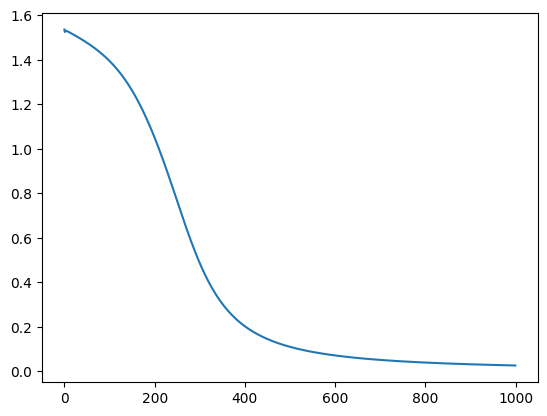

In [248]:
plt.plot(range(N_epochs),error_overTime)